# 📘 1. Introduction
This notebook explores user engagement metrics to support the design of a badge system
for a community platform. The analysis is based on a technical assessment and follows
a structured approach to:
- Understand the distribution and types of user activity
- Compare engagement behavior across multiple timeframes (4, 6, 8, 12 weeks)
- Identify stable and differentiating metrics
- Simulate threshold strategies for badge assignment

# 📥 2. Data Loading & Preparation


In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings 

warnings.filterwarnings('ignore')


In [2]:
# Load dataset
data = pd.read_csv('../data/data_analyst.csv')

# Print the first few rows of the dataset
data.head()

,USER_ID,LAST_X_WEEKS,POSTS_CREATED,REPLIES_RECEIVED,THANKYOUS_RECEIVED,EVENTS_CREATED,EVENT_PARTICIPANTS,ITEMS_GIFTED,PLACES_RECOMMENDED
0,1,4,1.0,0.0,6.0,NaN,NaN,NaN,NaN
1,1,6,1.0,0.0,6.0,NaN,NaN,NaN,NaN
2,1,8,1.0,0.0,6.0,NaN,NaN,NaN,NaN
3,1,12,2.0,0.0,6.0,NaN,NaN,NaN,NaN
4,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Convert column names to lowercase
data.columns = data.columns.str.lower()

# 80,000 rows in total and activity columns are of type float
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             80000 non-null  int64  
 1   last_x_weeks        80000 non-null  int64  
 2   posts_created       36101 non-null  float64
 3   replies_received    36101 non-null  float64
 4   thankyous_received  36101 non-null  float64
 5   events_created      5304 non-null   float64
 6   event_participants  5304 non-null   float64
 7   items_gifted        13224 non-null  float64
 8   places_recommended  7127 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 5.5 MB


In [4]:
# print basic summary statistics of the dataset - outliers across all columns except 'last_x_weeks' and 'user_id
data.describe()

,user_id,last_x_weeks,posts_created,replies_received,thankyous_received,events_created,event_participants,items_gifted,places_recommended
count,80000.000000,80000.000000,36101.000000,36101.000000,36101.000000,5304.000000,5304.000000,13224.000000,7127.000000
mean,10000.500000,7.500000,1.560455,2.804438,1.729869,1.747172,2.990196,1.832350,2.558861
std,5773.538769,2.958058,5.300670,5.023577,5.613324,2.073147,3.954328,2.153866,4.221170
min,1.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,5000.750000,5.500000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,10000.500000,7.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000
75%,15000.250000,9.000000,2.000000,4.000000,1.000000,2.000000,3.000000,2.000000,2.000000
max,20000.000000,12.000000,698.000000,139.000000,194.000000,36.000000,58.000000,58.000000,155.000000


## 🧰 2.1 Utility Functions

In [5]:
def last_x_weeks(data, week):
    return data[data['last_x_weeks'] == week]

def count_non_zero(column):
    return column[column > 0].count()

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def get_activity_summary(data, column):
    return data.groupby('last_x_weeks').agg({
        column : ['mean', 'std', 'median', 'max']
    }).reset_index()



# 📊 3. Exploratory Data Analysis (EDA)
<!-- Explore the overall distribution of key engagement metrics such as:
- Posts created
- Replies received
- Events and participation
- Items gifted
- Places recommended
- Thank-yous received

Plot histograms, CDFs, and boxplots to understand skewness and sparsity. -->

## 3.1 Missing Value Analysis

In [6]:
# Percentage of missing values in each column
missing_values = round(data.isna().sum() / len(data) * 100,2)
missing_values

user_id                0.00
last_x_weeks           0.00
posts_created         54.87
replies_received      54.87
thankyous_received    54.87
events_created        93.37
event_participants    93.37
items_gifted          83.47
places_recommended    91.09
dtype: float64

In [7]:
# Percentage of missing values by week and activity
missing_by_week = data.groupby('last_x_weeks').apply(lambda x: x.isna().sum() / 20000 * 100).drop(columns=['user_id', 'last_x_weeks'])
missing_by_week

,posts_created,replies_received,thankyous_received,events_created,event_participants,items_gifted,places_recommended
last_x_weeks,,,,,,,
4,73.980,73.980,73.980,95.755,95.755,90.245,94.775
6,62.485,62.485,62.485,94.410,94.410,86.070,92.570
8,51.755,51.755,51.755,93.120,93.120,82.040,90.635
12,31.275,31.275,31.275,90.195,90.195,75.525,86.385


In [8]:
# Fill missing values with 0. It is assumed that the missing values indicate that the user did not engage in that activity 
data = data.fillna(0)

# Convert data types 
activity_columns = ['posts_created', 'replies_received', 'thankyous_received', 'events_created', 'event_participants', 'items_gifted', 'places_recommended']
data[activity_columns] = data[activity_columns].astype(int)

## 3.2 Distribution Analysis

In [9]:
# Split data into different weeks
last_4_weeks = last_x_weeks(data, 4)
last_6_weeks = last_x_weeks(data, 6)
last_8_weeks = last_x_weeks(data, 8)
last_12_weeks = last_x_weeks(data, 12)

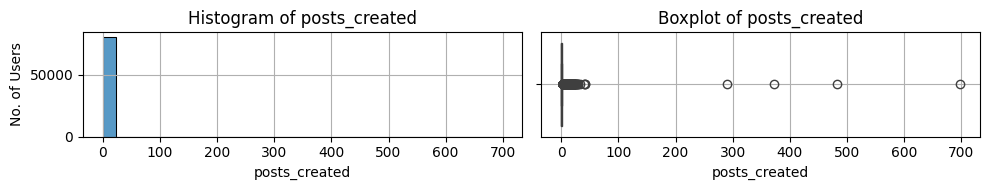

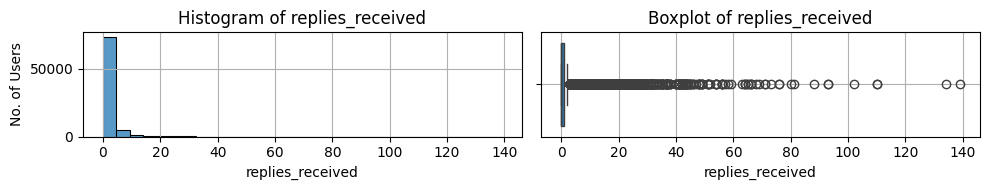

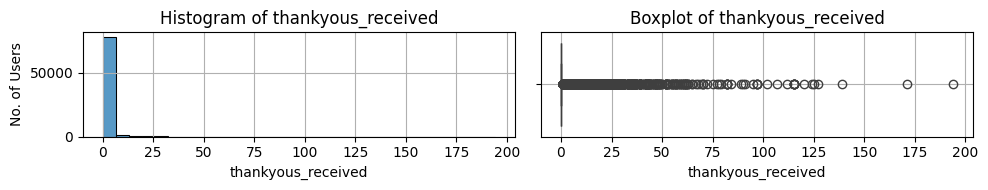

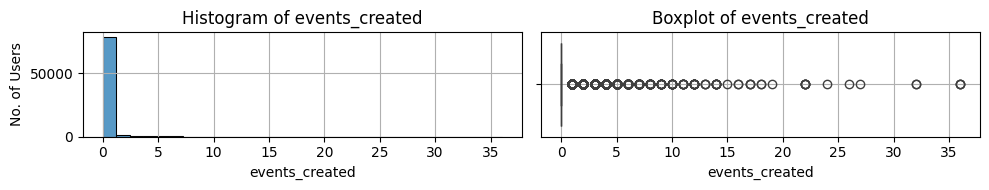

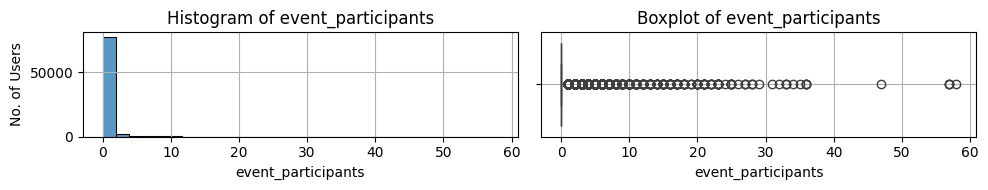

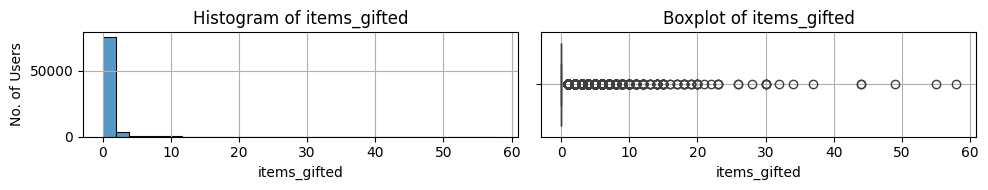

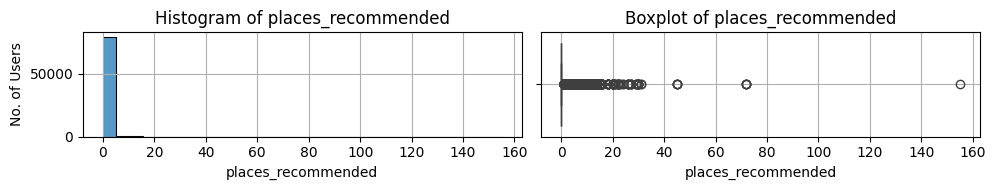

In [ ]:
# Plot histograms and boxplots for overall distribution of metrics
for col in activity_columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 2))  # 1 row, 2 columns
    
    # Histogram
    sns.histplot(data[col], bins=30, kde=False, ax=axes[0])
    axes[0].set_title(f"Histogram of {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("No. of Users")
    axes[0].grid(True)

    # Boxplot
    sns.boxplot(x=data[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")
    axes[1].set_xlabel(col)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# for col in activity_columns:

#     x = data[col].dropna().sort_values()
#     y = x.rank(method='first') / len(x)  # Compute cumulative probabilities

#     plt.figure(figsize=(6, 3))
#     plt.plot(x, y, marker='.', linestyle='none', hue=data)
#     plt.title(f"CDF of {col}")
#     plt.xlabel("Activity Count")
#     plt.ylabel("Cumulative Probability")
#     plt.grid(True)
#     plt.show()

## 3.3 Outlier Detection

## 3.4 Metric Comparison Across Timeframes

## 3.5 Correlations 

## 3.6 Engagement Segment Checks

In [ ]:
# # Example: Distribution of posts per week
# sns.histplot(df['posts_created_pw'], bins=50)
# plt.title("Posts Created per Week Distribution")
# plt.show()

# 📈 4. Timeframe Comparison
Compare how engagement metrics behave across the 4, 6, 8, and 12-week windows.
Assess:
- Metric stability: standard deviation, drift, range
- Engagement level trends: increasing or plateauing
- Active user proportions by metric and timeframe


In [ ]:
# Grouped summary by timeframe
df.groupby("last_x_weeks")["posts_created_pw"].describe()


# 📐 5. Metric Selection & Differentiation
Identify which metrics:
- Have clear separation between active and inactive users
- Are not dominated by noise or sparsity
- Maintain user ranking across timeframes (Spearman correlation)

These are the metrics best suited for badge assignment.

# 📏 6. Threshold Simulation
Use percentile-based thresholds (e.g., 75th, 90th) to:
- Simulate how many users would qualify per badge
- Define thresholds that are balanced (not too easy or too exclusive)
- Build badge categories based on different engagement types

Example badges:
- "Top Contributor": posts_created_pw ≥ 75th percentile
- "Helpful Neighbor": thankyous_received_pw ≥ 75th percentile
- "Conversation Starter": post_replies_ratio ≥ 1.0

In [ ]:
# Example: calculate thresholds
quantiles = df[df['last_x_weeks'] == 8]['posts_created_pw'].quantile([0.5, 0.75, 0.9])
print(quantiles)

# 🎯 7. Badge System Recommendations

Summarize badge logic:
- Which metrics and thresholds are used
- Which timeframe is selected (e.g., 8 weeks for balance and stability)
- How thresholds ensure fairness and meaning

Provide a final table of badge names, metrics, thresholds, and estimated coverage.

# ✅ 8. Conclusion
This analysis defines a defensible, data-backed badge system using engagement data.
The selected metrics and timeframe support stable and fair badge assignment across a diverse user base.
